# autocovariance & autocorrelation: estimation

The autocovariance or semi-variance is given by:

$
\begin{align}
\gamma(\tau) &= \frac{1}{2} \big \langle [ u(t+\tau) - u(t) ]^2 \big \rangle, \\
&= \big \langle (u-\mu)^2 \big \rangle
- \big \langle [ u(t+\tau) - \mu] [u(t)-\mu] \big \rangle
\end{align}
$


### references:
- [Priestley](https://www.google.com/search?q=10.1111%2F2041-210X.12176) (chapter 5):  Spectral analysis and timeseries

### illustration

Generate a 100 day time series with a 10 days decorrelation timescale

In [1]:
import xarray as xr
import numpy as np

# from numpy.linalg import inv, slogdet
# from scipy.optimize import minimize
# from scipy.stats import chi2
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

# import skgstat as skg
# from pprint import pprint

import sstats.tseries as ts
import sstats.sigp as sigp

/Users/aponte/.miniconda3/envs/stats/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# ts.exp_autocorr?

In [3]:
mu = 0  # true mean
sigma0 = 1  # true variance
T = 10  # days, decorrelation timescale

delta_T = 100  # time series length
dt = 3 / 24  # sampling interval in days

sigma_true = lambda tau: sigma0 * np.exp(-abs(tau) / T)

In [4]:
u = (
    mu
    + ts.exp_autocorr(
        (delta_T, dt),
        T,
        np.sqrt(sigma0),
        # burnin=int(10*T/dt),
        draws=1000,
        seed=0,
    ).compute()
)

# total number of points
N = u.time.size  # = delta_T/dt

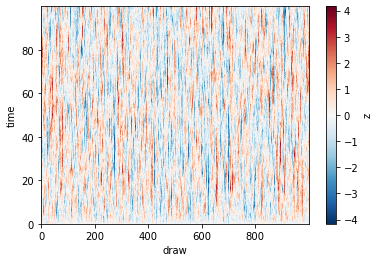

In [5]:
# dt=3 # hours
# u = ts.exp_autocorr((1000, dt/24), 10, 1, seed=0).compute()
u.plot()

Compute sample mean

The distribution of the sample mean is pretty wide owing to the strong autocorrelation of the data

In [6]:
ds = u.mean("time").rename("mu_hat").to_dataset()

/Users/aponte/.miniconda3/envs/stats/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


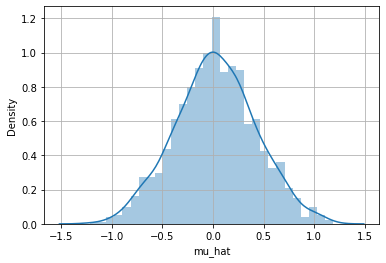

In [7]:
ax = sns.distplot(ds.mu_hat, bins=30, norm_hist=True)
ax.grid()

---

## distribution

Verifies Gaussianity.

Rigourous approaches:

- chi2 test
- QQ and PP tests
- Kolmogorov-Smirnov test [scipy kstest](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html)
- Normality test Jarque-Bera

[slides on these tests](https://laurentferraradotorg.files.wordpress.com/2016/01/test_np_p10_m1_fev16.pdf)

Do these tests apply with autocorrelated data? \
It seems no, see Weiss 78, Olea et al. 2009

Provided the decorrelation timescale is known, one can subsample the timeseries and apply the standard tests

In [8]:
def show_dist(pdf, ax, label="theoretical pdf", color="k", **kwargs):
    # stats.norm.pdf, loc=mu, scale=sigma0/np.sqrt(Neff)
    x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(x0, x1, 100)
    y_pdf = pdf(x_pdf, **kwargs)
    ax.plot(x_pdf, y_pdf, color=color, lw=2, label=label)

/Users/aponte/.miniconda3/envs/stats/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


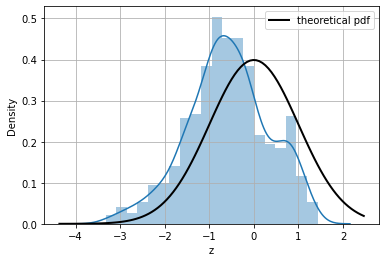

In [9]:
ax = sns.distplot(u.isel(draw=0), bins=20, norm_hist=True)
show_dist(
    stats.norm.pdf,
    ax,
    label="theoretical pdf",
    color="k",
    loc=mu,
    scale=np.sqrt(sigma0),
)
ax.grid()
ax.legend()

In [10]:
# with subsampling:
# stats.kstest?

---

## variance

We estimate the variance with confidence intervals

In [11]:
mean_Ne, sigma0_Ne, sigma0_scale = sigp.effective_DOF(sigma_true, dt, N)
print(mean_Ne, sigma0_Ne, sigma0_scale)

5.555439123081167 10.525709874446227 1.2179934083773847


In [12]:
# we anticipate the correction factor associate with the autocorrelation and small (effective) sample size
ds["sigma0_hat"] = u.var("time") * sigma0_scale

In [13]:
alpha = 0.1
ds["sigma0_lower"] = (
    (sigma0_Ne - 1) * ds.sigma0_hat / stats.chi2.ppf(1 - alpha / 2, sigma0_Ne)
)
ds["sigma0_upper"] = (
    (sigma0_Ne - 1) * ds.sigma0_hat / stats.chi2.ppf(alpha / 2, sigma0_Ne)
)

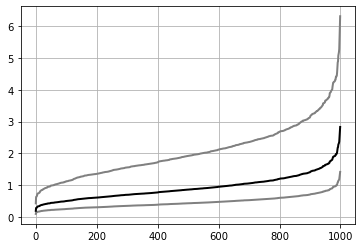

In [14]:
_ds = ds.sortby("sigma0_hat")

fig, ax = plt.subplots(1, 1)

# not working ... ?
# ax.fill_between(_ds.mu_lower.values, _ds.mu_upper.values)
# ax.fill_between(_ds.mu_upper.values, _ds.mu_lower.values)

ax.plot(_ds.sigma0_lower, "0.5", lw=2)
ax.plot(_ds.sigma0_upper, "0.5", lw=2)

ax.plot(_ds.sigma0_hat, "k", lw=2)
ax.grid()

percent_success = (
    _ds.where(
        (_ds.sigma0_upper > sigma0) & (_ds.sigma0_lower < sigma0), drop=True
    ).draw.size
    / _ds.draw.size
)

For draw 0:

In [15]:
_ds = ds.isel(draw=0)
print(
    f" variance= {float(_ds.sigma0_hat):.2f}  "
    + f" [{float(_ds.sigma0_lower):.2f} , "
    + f"{float(_ds.sigma0_upper):.2f}] at {(1-alpha)*100 }%"
)

 variance= 1.03   [0.52 , 2.29] at 90.0%


It turns out, draw 0 is pretty low ! \
But true estimate is indeed within the confidence interval estimate.

/Users/aponte/.miniconda3/envs/stats/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


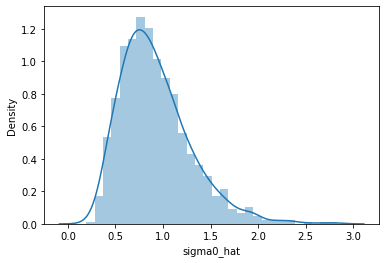

In [16]:
ax = sns.distplot(ds.sigma0_hat, bins=30, norm_hist=True)

---

## autocovariance

**To do:**

- choose appropriate estimate
- compare two models and select one
- simplify diagnostics

In [17]:
def plot_sigma(ds, label="sigma_hat"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    ds["sigma_true"].plot(ax=ax, label="truth")

    c_biased = "k"
    ds[label].quantile(0.05, "draw").plot(ax=ax, color=c_biased, label="biased")
    ds[label].quantile(0.95, "draw").plot(ax=ax, color=c_biased)

    c_unbiased = "cadetblue"
    ds[label + "_unbiased"].quantile(0.05, "draw").plot(
        ax=ax, color=c_unbiased, label="unbiased"
    )
    ds[label + "_unbiased"].quantile(0.95, "draw").plot(ax=ax, color=c_unbiased)

    ds[label].mean("draw").plot(
        color=c_biased,
    )  # label="mean"
    ds[label + "_unbiased"].mean("draw").plot(
        color=c_unbiased,
    )  # label="mean unbiased"

    ax.legend()

    ax.grid()

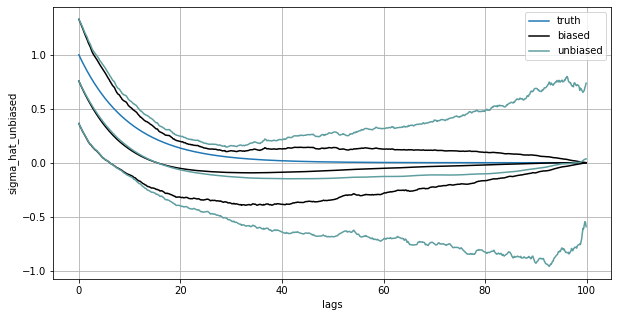

In [18]:
up = (u - ds["mu_hat"]).rename("u_p")

ds["sigma_hat"] = sigp.correlate(up, up)
ds["sigma_hat_unbiased"] = sigp.correlate(up, up, biased=False)

ds["sigma_true"] = sigma_true(ds.lags)

plot_sigma(ds)

### substracting the true (unknown) mean

The unbiased estimates is indeed unbiased. \
The biased estimate is indeed biased but the biias is relatively small.

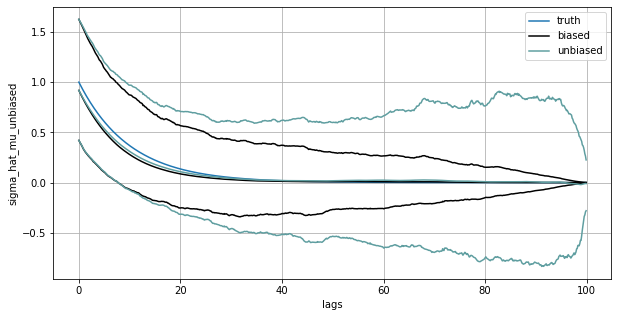

In [19]:
up = (u - mu).rename("u_p")

ds["sigma_hat_mu"] = sigp.correlate(u, u)
ds["sigma_hat_mu_unbiased"] = sigp.correlate(u, u, biased=False)

plot_sigma(ds, label="sigma_hat_mu")

### variance of the estimate

We compare next the observed variance of the variance estimate and compare it with the theoretical one estimated from autocoriance estimates as well as true autocovariances.

For small sample size (as here, i.e. 5 effective points), the observed variance is substantially smaller than theoretical predictions.

**biased covariance estimate:**

In [20]:
# estimate of the variance with the estimated auto-covariance (but with true mu)
ds["sigma_hat_var"] = sigp.barlett(ds.sigma_hat_mu, "lags").compute()

# estimate of the variance with the true auto-covariance
ds["sigma_hat_var_true"] = sigp.barlett(ds.sigma_true, "lags").compute()

Text(0.5, 1.0, 'variance of the biased covariance estimate')

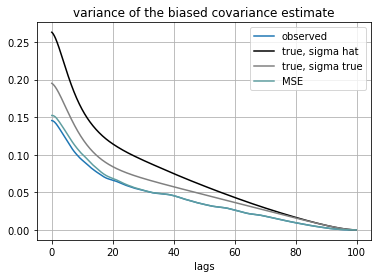

In [21]:
fig, ax = plt.subplots(1, 1)

# observed variance
ds["sigma_hat_mu"].var("draw").plot(label="observed")

# theoretical variance
(ds["sigma_hat_var"]).mean("draw").plot(color="k", label="true, sigma hat")
ds["sigma_hat_var_true"].plot(color="0.5", label="true, sigma true")

# MSE
MSE = ((ds["sigma_hat_mu"] - ds["sigma_true"]) ** 2).mean("draw")
MSE.plot(label="MSE", color="cadetblue")  # MSE not variance !!

ax.legend()
ax.grid()
ax.set_title("variance of the biased covariance estimate")

Using the variance estimate $\hat \sigma$ produces a variance that is twice larger than the actual one and this overestimations seems to be persist when the sample size is increased. \
Using the true variance does also produce an estimate that is about 30% too large compared to the actual one but this overestimation decreases when the sample size is increased.

As a side note, the mean square error is entirely driven by the variance of the estimate here.

**unbiased covariance estimate:**

Text(0.5, 1.0, 'variance of the unbiased covariance estimate')

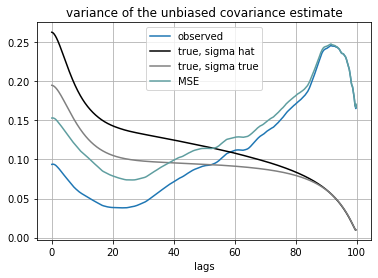

In [22]:
fig, ax = plt.subplots(1, 1)

# observed variance
ds["sigma_hat_unbiased"].var("draw").plot(label="observed")

# theoretical variance
scale = max(ds.lags) / (max(ds.lags) - ds.lags)
(scale * ds["sigma_hat_var"]).mean("draw").plot(color="k", label="true, sigma hat")
(scale * ds["sigma_hat_var_true"]).plot(color="0.5", label="true, sigma true")

MSE = ((ds["sigma_hat_unbiased"] - ds["sigma_true"]) ** 2).mean("draw")
MSE.plot(label="MSE", color="cadetblue")  # MSE not variance !!

ax.legend()
ax.grid()
ax.set_title("variance of the unbiased covariance estimate")

The variance is again overestimated with worst overestimation with the sampled autocovariance (which is what would be used in practice remember).

The increase of the variance (and mean square error) with lags is larger than theoretical expectations.\
Is this due to truncations in Barlett formulas.

As seen from the difference between MSE and the observed variance the bias is substantial (le comble pour un estimateur soit-disant "unbiased") and largest at small lags.

### mean square errors

Bias and variance are combined (generic relationships for all statistical estimates):
    
$
\begin{align}
MSE(\sigma) &= \langle (\hat \sigma - \sigma)^2 \rangle, \\
&= \langle (\hat \sigma - \langle \hat \sigma \rangle + \langle \hat \sigma \rangle - \sigma)^2 \rangle, \\
&= \langle (\hat \sigma - \langle \hat \sigma \rangle)^2 \rangle
+
(\langle \hat \sigma \rangle - \sigma)^2, \\
&= Var(\hat \sigma) + Bias^2(\hat \sigma)
\end{align}
$

Text(0.5, 1.0, 'mean square error')

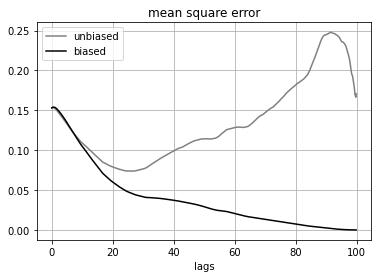

In [23]:
fig, ax = plt.subplots(1, 1)

# unbiased
MSE = ((ds["sigma_hat_unbiased"] - ds["sigma_true"]) ** 2).mean("draw")
MSE.plot(label="unbiased", color="0.5")  # MSE not variance !!

# biased
MSE = ((ds["sigma_hat"] - ds["sigma_true"]) ** 2).mean("draw")
MSE.plot(label="biased", color="k")  # MSE not variance !!

ax.legend()
ax.grid()
ax.set_title("mean square error")

### distribution

Select one lag, show & compare with theory

---

## MLE

**How does MLE perform compare to variogram fit ?**